# **Generalised Spectral Kernel Gaussian Process**


Credit: This code was written and expanded based on the *Kernel Learning for Explainable Climate Science* paper by Lalchand et al. In Lalchand et al, the Gibb's kernel is implemented for 1-dimensional input. This work adds to that by expanding to a grid of hyperparemters across mixtures, then update the conditional sampling methods and predive and forward methods so that it matches the dimensionality of the GSM Kernel. These correspond to the GSMKernel class and the DiagonalExactGP class, detail as below.

The training and prediction procedure for reproducing results are the same as other sing-task kernels.

For future work: Initialisation and training can be organised better in terms of joint tensors, whereby all parameters can be updated at once rather than separately as right now. That can helps to improve numerical stability at higher dimensional inputs.

Guidance for Reproducting Results:


1.   **Training Model**: Run all cells between beginning and "Main Training Cell". Set up configuration for the Main training cell: Choose number of iterations and initialisation. Set the correct path for saving check points for the model
2.   **Load Trained Model**: Run all cells from beginning and BEFORE "Main Training Cell". Next, start from "Load Saved Model and Make Predictions", modify the file path to the models desired, then run all cells after.

In [ ]:
!pip install gpytorch

In [ ]:
import pandas as pd
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv(r'/content/drive/MyDrive/STAT0035/Cleaned_data.csv', index_col = 0)

In [ ]:
data_sub = data[['Date.time',
 'Power.me',
 'Pot.Power.me',
 'Wind.speed.me',
 'Power.factor.cosphi.me',
 'Front.bearing.temp.me',
 'Rear.bearing.temp.me',
 'Stator1.temp.me',
 'Nacelle.ambient.temp.me',
 'Nacelle.temp.me',
 'Transformer.temp.me',
 'Gear.oil.temp.me',
 'Generator.bearing.rear.temp.me',
 'Generator.bearing.front.temp.me',
 'Gear.oil.temp.me.1',
 'Top.box.temp.me',
 'Hub.temp.me',
 'Conv.Amb.temp.me',
 'Rotor.bearing.temp.me',
 'Transformer.cell.temp.me',
 'Motor.axis1.temp.me',
 'Motor.axis2.temp.me',
 'Motor.axis3.temp.me',
 'CPU.temp.me',
 'Rotor.speed.me',
 'Blade.ang.pitch.pos.A.me',
 'Blade.ang.pitch.pos.B.me',
 'Blade.ang.pitch.pos.C.me',
 'Gear.oil.inlet.press.me',
 'Gear.oil.pump.press.me',
 'Drive.train.acceleration.me',
 'Tower.Acceleration.x',
 'Tower.Acceleration.y',
 'turbine',
 'year']]


### Standardise all variables except date-time

Scaling the dataset by subtracting mean and dividing by standard deviation

In [ ]:
# Remove negative power values
data_sub = data_sub[data_sub['Power.me'] >= 0]

In [ ]:
# Get the list of all columns
all_columns = data_sub.columns.tolist()

# Columns to exclude from scaling
exclude_columns = ['Date.time', 'turbine', 'year']

# Columns to be standardized (input features + output)
columns_to_standardize = [col for col in all_columns if col not in exclude_columns]

# Dictionary to store mean and standard deviation for each column
standardization_parameters = {}

# Standardization
for col in columns_to_standardize:
    mean = data_sub[col].mean()
    std = data_sub[col].std()
    standardization_parameters[col] = {'mean': mean, 'std': std}
    data_sub[col] = (data_sub[col] - mean) / std

### Filtering data

In [ ]:
# Filter out Turbine 1
data_turbine_1 = data_sub[data_sub['turbine'] == 1]

So it can be seen that the relationship is linear between windspeed = -0.2 and windspeed = 1.3

### Training with SM Gaussian Processes

In [ ]:
# FOR 1,000 POINTS
# train_df = data_turbine_1.iloc[:80000:40].fillna(0)
# # test_df = data_turbine_1.iloc[80000:100000:40].fillna(0)
# test_df = data_turbine_1.iloc[80000:100000:5].fillna(0)

train_df = data_turbine_1.iloc[:70000:10].fillna(0)
# test_df = data_turbine_1.iloc[70000:105000:20].fillna(0)
test_df = data_turbine_1.iloc[70000:70000+10080].fillna(0)

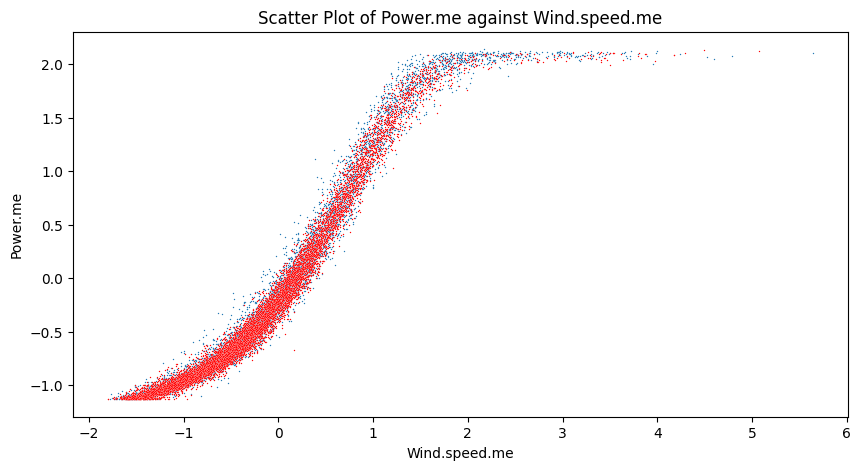

In [ ]:
# Find where the relationship is linear
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Wind.speed.me', y='Power.me', data=train_df, s = 1)
sns.scatterplot(x='Wind.speed.me', y='Power.me', data=test_df, s = 1, color = 'red')
plt.title('Scatter Plot of Power.me against Wind.speed.me')
plt.xlabel('Wind.speed.me')
plt.ylabel('Power.me')
plt.show()

In [ ]:
training_var = [
 'Wind.speed.me',
#  'Power.factor.cosphi.me',
#  'Front.bearing.temp.me',
#  'Stator1.temp.me',
#  'Nacelle.ambient.temp.me',
#  'Nacelle.temp.me',
#  'Transformer.temp.me',
#  'Gear.oil.temp.me',
#  'Generator.bearing.rear.temp.me',
#  'Generator.bearing.front.temp.me',
#  'Motor.axis1.temp.me',
#  'CPU.temp.me',
#  'Rotor.speed.me',
#  'Gear.oil.inlet.press.me',
#  'Drive.train.acceleration.me',
#  'Tower.Acceleration.x',
#  'Tower.Acceleration.y',
 ]
train_x = torch.tensor(train_df[training_var].values)
train_y = torch.tensor(train_df['Power.me'].values)
test_x = torch.tensor(test_df[training_var].values)
test_y = torch.tensor(test_df['Power.me'].values)

### Non-Stationary Kernel CKL

In [ ]:
"""
Convenience functions, mainly for abstracting torch's linear algebra with terser names and better batching.
"""

from typing import Optional
import math
import torch
import bisect
from collections import namedtuple


def dot(v1: torch.Tensor, v2: torch.Tensor) -> torch.Tensor:
    """Compute the batch dot product v1^T v2"""
    return (v1 * v2).sum(-1)


def t(x: torch.Tensor) -> torch.Tensor:
    """Matrix transpose"""
    return torch.transpose(x, -1, -2)


def tr(x: torch.Tensor) -> torch.Tensor:
    """Trace"""
    return torch.diagonal(x, dim1=-1, dim2=-2).sum(-1)


def mv(matrix: torch.Tensor, vector: torch.Tensor, invert=False) -> torch.Tensor:
    if invert is False:
        return torch.squeeze(matrix @ torch.unsqueeze(vector, -1), -1)
    else:
        return torch.linalg.solve(matrix, vector.unsqueeze(-1)).squeeze(-1)

def quad(v: torch.Tensor, matrix: torch.Tensor, v2: torch.Tensor = None, invert: bool = False) -> torch.Tensor:
    if v2 is None:
        v2 = v.clone()
    if invert == True:
        # WARNING: need to add a final dimension to v2 for it to be treated as a vector, contrary to docs
        v2 = torch.linalg.solve(matrix, v2.unsqueeze(-1)).squeeze(-1)
    else:
        v2 = mv(matrix, v2)
    return dot(v, v2)

def expquad(
    v: torch.Tensor,
    matrix: torch.Tensor,
    invert: bool = False,
    out_scale: torch.Tensor = torch.tensor(1.0),
    exp_scale: torch.tensor = torch.tensor(0.5),
) -> torch.Tensor:
    return out_scale * torch.exp(-exp_scale * quad(v, matrix, invert=invert))


def sym(x: torch.Tensor) -> torch.Tensor:
    """Force symmetry"""
    return 0.5 * (x + t(x))


def op(v1: torch.Tensor, v2: Optional[torch.Tensor]=None) -> torch.Tensor:
    """Vector outer product"""
    if v2 is None:
        v2 = v1
    return v1.unsqueeze(-1) @ v2.unsqueeze(-2)


def bisect_right(array, value, tol=1e-8):
    """Bisect right which is robust up to a tolerance. Returns the index i to insert
    value in (sorted) array such that array[j] <= value+tol for j < i, array[j] > value+tol
    for j >= i. tol should be smaller than gaps between values, and used to avoid issues with
    floating points only."""
    if isinstance(array, torch.Tensor):
        array = array.cpu().numpy()
    return bisect.bisect_right(array, value + tol)


def bisect_left(array, value, tol=1e-8):
    if isinstance(array, torch.Tensor):
        array = array.cpu().numpy()
    return bisect.bisect_left(array, value + tol)


def vec(x: torch.Tensor):
    """Vectorises a matrix"""
    batch_shape = x.shape[:-2]
    return t(x).contiguous().view(*batch_shape, x.shape[-2] * x.shape[-1])


def vech(x: torch.Tensor):
    """Half vectorisation of a matrix, i.e. vectorises the lower triangle"""
    D = x.shape[-2]
    if not x.shape[-1] == D:
        raise ValueError("Matrix must be square for half vectorisation, but got shape {}".format(x.shape))
    return x[..., torch.tril(torch.ones(D, D)) == 1]


def kron(x: torch.Tensor, y: torch.Tensor):
    """Batch kronecker product of matrices"""
    size1 = torch.Size(torch.tensor(x.shape[-2:]) * torch.tensor(y.shape[-2:]))
    res = x.unsqueeze(-1).unsqueeze(-3) * y.unsqueeze(-2).unsqueeze(-4)
    size0 = res.shape[:-4]
    return res.reshape(size0 + size1)


def duplication_matrix(n: int):
    out = torch.zeros(n ** 2, n * (n + 1) // 2)
    for j in range(1, n + 1):
        for i in range(j, n + 1):
            u = torch.zeros(n * (n + 1) // 2)
            u[(j - 1) * n + i - j * (j - 1) // 2 - 1] = 1.0
            T = torch.zeros(n, n)
            T[i - 1, j - 1] = 1.0
            T[j - 1, i - 1] = 1.0
            out = out + op(vec(T), u)
    return out


def diff(x, boundary_value=None, dim=-2):
    """Return the forward differences (output[...,n] is x[...,n+1]-x[...,n]). To retain length, the final value should be
    given, else it will be replaced by replicating the penultimate."""
    x = x.transpose(dim, -1)
    diff_x = (x[..., 1:] - x[..., :-1]).view(*x.shape[:-1], x.shape[-1] - 1)
    if boundary_value is None:
        boundary_value = diff_x[..., -1]
    return torch.cat((diff_x, boundary_value.unsqueeze(-1)), dim=-1).transpose(dim, -1)


def normalise(x: torch.Tensor, **kwargs):
    """x is normalised to be zero mean and unit norm over the last dimension. Extra kwargs are passed to
    pytorch's normalize to e.g. change the norm, dimension, ..."""
    if "dim" in kwargs.keys():
        dim = kwargs["dim"]
    else:
        dim = -1
    x = x - torch.mean(x, dim=dim, keepdim=True)
    return math.sqrt(x.shape[dim]) * torch.nn.functional.normalize(x, **kwargs)


def project_pca(D: int, y: torch.Tensor):
    """For y (..., N, Delta), project y onto the D directions of maximum variance"""
    eigenvals, eigenvecs = torch.linalg.eigh(t(y) @ y)
    Result = namedtuple("result", "projection matrix")
    return Result(mv(t(eigenvecs[..., -D:]), y), t(eigenvecs[..., -D:]))


def project_lstsq(y: torch.Tensor, C: torch.Tensor, d: torch.Tensor):
    """Assuming y = Cx+d, return the least squares solution for x."""
    soln = torch.linalg.lstsq(C, t(y - d))
    Result = namedtuple("result", "projection matrix")
    return Result(t(soln.solution), C)

def robust_logdet(x : torch.Tensor, init_scale=1e-30, max_scale = 1e-6) -> torch.Tensor:
    """Does logdet of batched matrices, adding diagonal terms until max_scale is reached, or no nan values.

    The diagonal matrix is a scaled identity matrix added to all batches."""
    out = torch.logdet(x)
    if torch.any(torch.isnan(out)):
        reg = init_scale * torch.eye(x.shape[-1]).to(x.device)
        while reg[0,0].squeeze() <= max_scale and torch.any(torch.isnan(out)):
            out = torch.logdet(x + reg)
            reg = reg * 10
    return out

In [ ]:
"""
Classes of a GP model with GSM Kernel with specific prior processes.

Classes
-------
PositivePriorProcess:
    A minimal base class for prior processes.

    Methods
    -------
    forward():
        Returns a distribution based on the parameterization (distribution of the unconstrained value).
    sample():
        Returns the actual positive value.
    conditional_sample():
        Returns the actual positive value conditioned on some input.

LogNormalPriorProcess:
    Applies a GP prior on the logarithmic value of the input with independent treatment per dimension.

    Parameters
    ----------
    input_dim : int, default=1
        The input dimension for the GP.
    covariance_function : gpytorch.kernel.Kernel, optional
        The covariance function used for the GP, defaults to a scaled RBF kernel if not provided.

    Method
    ------
    conditional_sample():
        Returns a single sample at the conditional mean.
"""
import math
import torch
import gpytorch
from typing import Tuple, Optional
from linear_operator.operators import to_dense

class PositivePriorProcess(torch.nn.Module):
    """Base class for lengthscale prior processes."""

    def __init__(self, *args, **kwargs) -> None:
        super().__init__()


    def forward(self,
               x : torch.Tensor) -> torch.distributions.Distribution:
        """Returns some distribution; depends on the parameterisation"""
        raise NotImplementedError

    def sample(self,
              x : torch.Tensor,
               **kwargs) -> torch.Tensor:
        """Returns sampled positive vector (..., D,) or positive matrix (..., D, D,) at input locations x"""
        raise NotImplementedError

    def conditional_sample(self,
                           x : torch.Tensor,
                           given : Tuple[torch.Tensor, torch.Tensor],
                           **kwargs) -> torch.Tensor:
        """Returns sampled positive vector (..., D,) or positive matrix (..., D, D,) at input locations x,
        conditioned on the process being given[1] at inputs given[0]."""
        raise NotImplementedError

class LogNormalPriorProcess(PositivePriorProcess):
    """D independent GPs for the log-value."""
    def __init__(self, input_dim : int=1, covariance_function : gpytorch.kernels.Kernel=None, active_dims=None) -> None:
        super().__init__()
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size((input_dim,)))

        """
        ard_num_dims is done at the parameter level, not the main kernel. So we don't sample multiple lengthscales at one.
        We sample one lengthscale that is modelled by multiple lower-hierachical ARD legthscale.

        """
        if covariance_function is None:
            covariance_function = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(
                ard_num_dims=input_dim, batch_shape=torch.Size((input_dim,)), active_dims=active_dims), batch_shape=torch.Size((input_dim,)), active_dims=active_dims
            )
        self.covar_module = covariance_function

    def forward(self, x : torch.Tensor) -> torch.distributions.MultivariateNormal:
        """Returns log-value distribution"""
        return gpytorch.distributions.MultivariateNormal(self.mean_module(x),
                                                        self.covar_module(x))

    def sample(self, x : torch.Tensor, **kwargs) -> torch.Tensor:
        return torch.exp(self.forward(x).rsample(**kwargs))

    def conditional_sample(self, x : torch.Tensor,
                           given : Tuple[torch.Tensor, torch.Tensor],
                           **kwargs) -> torch.Tensor:
        prior_dist_given = self(given[0])
        prior_x = self.forward(x)
        K_xg = self.covar_module(x, given[0]).evaluate()
        K_xg = K_xg.permute(*range(1, len(K_xg.shape)-1), 0, -1)
        prior_mean = prior_x.mean.permute(*range(1, len(prior_x.mean.shape)), 0)
        jitter = 1e-4 * torch.eye(given[0].shape[-2])
        mu = prior_mean + dot(K_xg, mv(prior_dist_given.covariance_matrix + jitter,
                                        torch.log(given[1]) - prior_dist_given.mean,
                                        invert=True
                                        )
                                  )
        return torch.exp(mu).permute(-1, *range(0, len(mu.shape)-1))

    def log_prob(self, x_and_logell : Tuple[torch.Tensor, torch.Tensor]):
        """returns log probability of output"""
        x, log_value = x_and_logell
        #log_value = torch.log(ell)
        mu = self.mean_module(x)
        sigma = self.covar_module(x) + 1e-4 * torch.eye(x.shape[-2]).to(x.device)
        out = gpytorch.distributions.MultivariateNormal(mu, sigma).log_prob(log_value)
        return out/x.shape[-2]

In [ ]:
"""
A non-stationary Generalised Spectral Mixture (GSM) kernel that models each input with a mixture of Gaussian components.
This kernel allows separate parameter sets (weights, lengthscales, frequency means) for each component in the mixture,
indexed by _1 and _2. Each of these also has GP prior, which will be registered after.

Parameters
----------
*args :
    Positional arguments for kernel configuration.
weight_prior_1 : PositivePriorProcess, optional
    Prior process for the weights of the first mixture component.
weight_prior_2 : PositivePriorProcess, optional
    Prior process for the weights of the second mixture component.
lengthscale_prior_1 : PositivePriorProcess, optional
    Prior process for the lengthscales of the first mixture component.
lengthscale_prior_2 : PositivePriorProcess, optional
    Prior process for the lengthscales of the second mixture component.
frequencymean_prior_1 : PositivePriorProcess, optional
    Prior process for the frequency means of the first mixture component.
frequencymean_prior_2 : PositivePriorProcess, optional
    Prior process for the frequency means of the second mixture component.
**kwargs :
    Keyword arguments for further customization.

Methods
-------
forward(x1, x2, **kwargs) -> torch.Tensor
    Computes the kernel matrix using the parameters from the Gaussian Spectral Mixture. If `x1` and `x2` are different
    and only one set of mixture parameters is provided, the other set is conditionally sampled.
"""

class GSMKernel(gpytorch.kernels.Kernel):

    is_stationary = False

    def __init__(self,
                 *args,
                 weight_prior_1: PositivePriorProcess = None,
                 weight_prior_2: PositivePriorProcess = None,
                 lengthscale_prior_1: PositivePriorProcess = None,
                 lengthscale_prior_2: PositivePriorProcess = None,
                 frequencymean_prior_1: PositivePriorProcess = None,
                 frequencymean_prior_2: PositivePriorProcess = None,
                 **kwargs,
                ) -> None:
        """GSM kernel with separate priors for two sets of parameters.

        Each `*_prior_1` and `*_prior_2` represents a PositivePriorProcess for the respective set of parameters.
        """
        super().__init__(*args, **kwargs)
        self.weight_prior_1 = weight_prior_1
        self.weight_prior_2 = weight_prior_2
        self.lengthscale_prior_1 = lengthscale_prior_1
        self.lengthscale_prior_2 = lengthscale_prior_2
        self.frequencymean_prior_1 = frequencymean_prior_1
        self.frequencymean_prior_2 = frequencymean_prior_2


    @property
    def batch_shape(self):
        """Overriding normal behaviour to avoid setting batch shape based on prior's kernels."""
        return self._batch_shape

    def forward(self,
                x1 : torch.Tensor,
                x2 : torch.Tensor,

                w1_1 : Optional[torch.Tensor] = None,
                w2_1 : Optional[torch.Tensor] = None,
                ell1_1 : Optional[torch.Tensor] = None,
                ell2_1 : Optional[torch.Tensor] = None,
                miu1_1 : Optional[torch.Tensor] = None,
                miu2_1 : Optional[torch.Tensor] = None,

                w1_2 : Optional[torch.Tensor] = None,
                w2_2 : Optional[torch.Tensor] = None,
                ell1_2 : Optional[torch.Tensor] = None,
                ell2_2 : Optional[torch.Tensor] = None,
                miu1_2 : Optional[torch.Tensor] = None,
                miu2_2 : Optional[torch.Tensor] = None,
                **kwargs
               ) -> torch.Tensor:
        """Computes the GSM kernel matrix. ell1, ell2 are assumed to be the kernel lengthscales at
        x1 and x2 respectively. If only ell1 is given, and x1 =/= x2, then ell2 is sampled conditionally."""

        ############################# Sampling for parameters ending with _1 #################################

        if w1_1 is None:
            w1_1 = self.weight_prior_1.sample(x1)
            self.w1_1 = w1_1

        if torch.equal(x1, x2):
            w2_1 = w1_1
        else:
            if w2_1 is None:
                w2_1 = self.weight_prior_1.conditional_sample(x2, given=(x1, w1_1))
                self.w2_1 = w2_1

        if ell1_1 is None:
            ell1_1 = self.lengthscale_prior_1.sample(x1)
            self.ell1_1 = ell1_1

        if torch.equal(x1, x2):
            ell2_1 = ell1_1
        else:
            if ell2_1 is None:
                ell2_1 = self.lengthscale_prior_1.conditional_sample(x2, given=(x1, ell1_1))
                self.ell2_1 = ell2_1

        if miu1_1 is None:
            miu1_1 = self.frequencymean_prior_1.sample(x1)
            self.miu1_1 = miu1_1

        if torch.equal(x1, x2):
            miu2_1 = miu1_1
        else:
            if miu2_1 is None:
                miu2_1 = self.frequencymean_prior_1.conditional_sample(x2, given=(x1, miu1_1))
                self.miu2_1 = miu2_1

        ############################# Sampling for parameters ending with _2 #################################

        if w1_2 is None:
            w1_2 = self.weight_prior_2.sample(x1)
            self.w1_2 = w1_2

        if torch.equal(x1, x2):
            w2_2 = w1_2
        else:
            if w2_2 is None:
                w2_2 = self.weight_prior_2.conditional_sample(x2, given=(x1, w1_2))
                self.w2_2 = w2_2

        if ell1_2 is None:
            ell1_2 = self.lengthscale_prior_2.sample(x1)
            self.ell1_2 = ell1_2

        if torch.equal(x1, x2):
            ell2_2 = ell1_2
        else:
            if ell2_2 is None:
                ell2_2 = self.lengthscale_prior_2.conditional_sample(x2, given=(x1, ell1_2))
                self.ell2_2 = ell2_2

        if miu1_2 is None:
            miu1_2 = self.frequencymean_prior_2.sample(x1)
            self.miu1_2 = miu1_2

        if torch.equal(x1, x2):
            miu2_2 = miu1_2
        else:
            if miu2_2 is None:
                miu2_2 = self.frequencymean_prior_2.conditional_sample(x2, given=(x1, miu1_2))
                self.miu2_2 = miu2_2


        ############################# Computing element RESULT 1 #################################

        sq_sum_1 = (ell1_1.unsqueeze(-1)**2 + ell2_1.unsqueeze(-2)**2)
        out_1 = torch.sqrt(2 * op(ell1_1, ell2_1) / sq_sum_1)
        out_1 = torch.prod(out_1, dim=-3)
        diff_1 = x1.unsqueeze(-2) - x2.unsqueeze(-3)
        GIBB_1 = out_1 * torch.exp(-torch.sum(diff_1**2 / sq_sum_1.permute(*range(len(sq_sum_1.shape)-3), -2, -1, -3), dim=-1))


        W_1 = op(w1_1, w2_1).squeeze()
        # print(W_1.shape)
        # W_reduced_1 = torch.prod(W_1, dim=-3)

        # x1_transposed = x1.t()
        # x2_transposed = x2.t()
        # COS_1 = torch.cos(torch.pi * ((miu1_1.squeeze() * x1_transposed.squeeze()).unsqueeze(-1) - (miu2_1.squeeze() * x2_transposed.squeeze()).unsqueeze(-2)))
        # COS_reduced_1 = torch.prod(COS_1, dim=-3)
        COS_1 = torch.cos(torch.pi * ((miu1_1.squeeze() * x1.squeeze()).unsqueeze(-1) - (miu2_1.squeeze() * x2.squeeze()).unsqueeze(-2)))


        result_1 = W_1 * GIBB_1 * COS_1

        ############################# Computing element RESULT 2 #################################

        sq_sum_2 = (ell1_2.unsqueeze(-1)**2 + ell2_2.unsqueeze(-2)**2)
        out_2 = torch.sqrt(2 * op(ell1_2, ell2_2) / sq_sum_2)
        out_2 = torch.prod(out_2, dim=-3)
        diff_2 = x1.unsqueeze(-2) - x2.unsqueeze(-3)
        GIBB_2 = out_2 * torch.exp(-torch.sum(diff_2**2 / sq_sum_2.permute(*range(len(sq_sum_2.shape)-3), -2, -1, -3), dim=-1))

        W_2 = op(w1_2, w2_2).squeeze()
        # W_reduced_2 = torch.prod(W_2, dim=-3)

        # COS_2 = torch.cos(torch.pi * ((miu1_2.squeeze() * x1_transposed.squeeze()).unsqueeze(-1) - (miu2_2.squeeze() * x2_transposed.squeeze()).unsqueeze(-2)))
        # COS_reduced_2 = torch.prod(COS_2, dim=-3)
        COS_2 = torch.cos(torch.pi * ((miu1_2.squeeze() * x1.squeeze()).unsqueeze(-1) - (miu2_2.squeeze() * x2.squeeze()).unsqueeze(-2)))


        result_2 = W_2 * GIBB_2 * COS_2

        return result_1 + result_2

class GSMSafeScaleKernel(gpytorch.kernels.ScaleKernel):
    @property
    def batch_shape(self):
        """Overriding normal behaviour to avoid setting batch shape based on prior's kernels."""
        return self._batch_shape

In [ ]:
"""
Implements a Gaussian Process (GP) model using a diagonal Generalised Spectral Mixture (GSM) kernel.
This model performs Maximum A Posteriori (MAP) inference with explicit management of multiple sets
of kernel hyperparameters, each corresponding to a different component in the mixture model.

This model is equipped with separate registers for weights, lengthscales, and frequency means for each
mixture component (_1 and _2), enabling flexible and targeted parameter control during training and prediction.
The kernel's parameters are managed via registration of parameters and priors, allowing for conditional sampling
based on training inputs.

Parameters
----------
train_x : torch.Tensor
    Training input data (features).
train_y : torch.Tensor
    Training target data (labels).
likelihood : gpytorch.likelihoods.Likelihood
    Likelihood model to apply to the GP's outputs.
prior : PositivePriorProcess
    A prior process that is used for all hyperparameters of the GSM kernel.
num_dim : int, optional
    The number of dimensions for the Automatic Relevance Determination (ARD) in the kernel (default is 1).

Methods
-------
forward(x) -> gpytorch.distributions.MultivariateNormal
    Computes the predictive mean and covariance at a given input x using the current model parameters.
    Exponentiates the log-transformed parameters before passing them to the kernel.

predict(x_new) -> gpytorch.distributions.MultivariateNormal
    Generates predictions at new data points x_new. This involves conditionally sampling new kernel parameters
    based on the values estimated from the training data and using them to compute the covariance matrices
    needed for the predictive distribution. It calculates the predictive mean and variance by leveraging the
    properties of the conditional Gaussian distribution.
"""

import torch
import gpytorch

class DiagonalExactGP(gpytorch.models.ExactGP):
    """Model for MAP inference of diagonal GSM kernel GP."""
    def __init__(self, train_x, train_y, likelihood, prior, num_dim=1):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = GSMSafeScaleKernel(
                GSMKernel(weight_prior_1=prior, weight_prior_2=prior,
                            lengthscale_prior_1=prior, lengthscale_prior_2=prior,
                            frequencymean_prior_1=prior, frequencymean_prior_2=prior,
                            ard_num_dims=num_dim))

        # Register for weight _1
        self.register_parameter('log_w_train_x_1',
                                torch.nn.Parameter(
                                    self.covar_module.base_kernel.weight_prior_1.forward(train_x).mean.clone()
                                ))
        self.register_prior('w_train_prior_1',
                            self.covar_module.base_kernel.weight_prior_1,
                            lambda module : (module.train_inputs[0], module.log_w_train_x_1))

        # Register for weight _2
        self.register_parameter('log_w_train_x_2',
                                torch.nn.Parameter(
                                    self.covar_module.base_kernel.weight_prior_2.forward(train_x).mean.clone()
                                ))
        self.register_prior('w_train_prior_2',
                            self.covar_module.base_kernel.weight_prior_2,
                            lambda module : (module.train_inputs[0], module.log_w_train_x_2))

        # Register for lengthscale _1
        self.register_parameter('log_ell_train_x_1',
                                torch.nn.Parameter(
                                    self.covar_module.base_kernel.lengthscale_prior_1.forward(train_x).mean.clone()
                                ))
        self.register_prior('ell_train_prior_1',
                            self.covar_module.base_kernel.lengthscale_prior_1,
                            lambda module : (module.train_inputs[0], module.log_ell_train_x_1))

        # Register for lengthscale _2
        self.register_parameter('log_ell_train_x_2',
                                torch.nn.Parameter(
                                    self.covar_module.base_kernel.lengthscale_prior_2.forward(train_x).mean.clone()
                                ))
        self.register_prior('ell_train_prior_2',
                            self.covar_module.base_kernel.lengthscale_prior_2,
                            lambda module : (module.train_inputs[0], module.log_ell_train_x_2))

        # Register for frequency mean _1
        self.register_parameter('log_miu_train_x_1',
                                torch.nn.Parameter(
                                    self.covar_module.base_kernel.frequencymean_prior_1.forward(train_x).mean.clone()
                                ))
        self.register_prior('miu_train_prior_1',
                            self.covar_module.base_kernel.frequencymean_prior_1,
                            lambda module : (module.train_inputs[0], module.log_miu_train_x_1))

        # Register for frequency mean _2
        self.register_parameter('log_miu_train_x_2',
                                torch.nn.Parameter(
                                    self.covar_module.base_kernel.frequencymean_prior_2.forward(train_x).mean.clone()
                                ))
        self.register_prior('miu_train_prior_2',
                            self.covar_module.base_kernel.frequencymean_prior_2,
                            lambda module : (module.train_inputs[0], module.log_miu_train_x_2))

    # Need to exponentiating here again because we run forward() above, not sample()
    def forward(self, x):
        mean = self.mean_module(x)

        covar = self.covar_module(x,
                                  w1_1=torch.exp(self.log_w_train_x_1),
                                  w1_2=torch.exp(self.log_w_train_x_2),
                                  ell1_1=torch.exp(self.log_ell_train_x_1),
                                  ell1_2=torch.exp(self.log_ell_train_x_2),
                                  miu1_1=torch.exp(self.log_miu_train_x_1),
                                  miu1_2=torch.exp(self.log_miu_train_x_2))

        return gpytorch.distributions.MultivariateNormal(mean, covar)


    def predict(self, x_new):
        """Returns predictive at x_new given estimate of hyperparameters at training points."""

        K_xx = self.covar_module(self.train_inputs[0],
                                ell1_1=torch.exp(self.log_ell_train_x_1),
                                ell1_2=torch.exp(self.log_ell_train_x_2),
                                w1_1=torch.exp(self.log_w_train_x_1),
                                w1_2=torch.exp(self.log_w_train_x_2),
                                miu1_1=torch.exp(self.log_miu_train_x_1),
                                miu1_2=torch.exp(self.log_miu_train_x_2)).evaluate()

        # Sampling new parameters based on the input x_new
        ell2_1 = self.covar_module.base_kernel.lengthscale_prior_1.conditional_sample(x_new, given=(self.train_inputs[0], torch.exp(self.log_ell_train_x_1)))
        w2_1 = self.covar_module.base_kernel.weight_prior_1.conditional_sample(x_new, given=(self.train_inputs[0], torch.exp(self.log_w_train_x_1)))
        miu2_1 = self.covar_module.base_kernel.frequencymean_prior_1.conditional_sample(x_new, given=(self.train_inputs[0], torch.exp(self.log_miu_train_x_1)))

        ell2_2 = self.covar_module.base_kernel.lengthscale_prior_2.conditional_sample(x_new, given=(self.train_inputs[0], torch.exp(self.log_ell_train_x_2)))
        w2_2 = self.covar_module.base_kernel.weight_prior_2.conditional_sample(x_new, given=(self.train_inputs[0], torch.exp(self.log_w_train_x_2)))
        miu2_2 = self.covar_module.base_kernel.frequencymean_prior_2.conditional_sample(x_new, given=(self.train_inputs[0], torch.exp(self.log_miu_train_x_2)))

        K_ss = self.covar_module(x_new, ell1_1=ell2_1, ell1_2=ell2_2, w1_1=w2_1, w1_2=w2_2, miu1_1=miu2_1, miu1_2=miu2_2).evaluate()
        K_sx = self.covar_module(x_new, self.train_inputs[0],
                                ell1_1=ell2_1, ell1_2=ell2_2, w1_1=w2_1, w1_2=w2_2, miu1_1=miu2_1, miu1_2=miu2_2,
                                ell2_1=torch.exp(self.log_ell_train_x_1), ell2_2=torch.exp(self.log_ell_train_x_2),
                                w2_1=torch.exp(self.log_w_train_x_1), w2_2=torch.exp(self.log_w_train_x_2),
                                miu2_1=torch.exp(self.log_miu_train_x_1), miu2_2=torch.exp(self.log_miu_train_x_2)).evaluate()

        # Calculating mu and sigma
        mu = torch.matmul(K_sx, torch.linalg.solve(K_xx + (self.likelihood.noise) * torch.eye(K_xx.shape[-1]).to(K_xx.device), self.train_targets))
        sigma = K_ss - torch.matmul(torch.matmul(K_sx, torch.inverse(K_xx + (self.likelihood.noise) * torch.eye(K_xx.shape[-1]).to(K_xx.device))), torch.transpose(K_sx, -2, -1))

        f_pred = gpytorch.distributions.MultivariateNormal(mu, covariance_matrix=sigma + 1e-4 * torch.eye(K_ss.shape[-1]).to(K_ss.device))
        return f_pred

In [ ]:
# Function to initialise model and likelihood objects
def create_model_and_likelihood(train_x, train_y, prior):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = DiagonalExactGP(train_x, train_y, likelihood, prior)
    return model, likelihood

# Function to save the model and likelihood with an initialization identifier
def save_checkpoint(model, likelihood, iteration, init, folder='/content/drive/MyDrive/STAT0035/Term 2 Reading Week/GSM - 7k - Q2 (1 to 3)'):
    os.makedirs(folder, exist_ok=True)
    torch.save(model.state_dict(), f'{folder}/model_state_init{init}_iter{iteration}.pth')
    torch.save(likelihood.state_dict(), f'{folder}/likelihood_state_init{init}_iter{iteration}.pth')

### Main Training Cell
*  We can skip this cell if we want to load saved model
*  Parameters to we aware of:


1.   Range of initialisation (if the training breaks at 4, insert 4 in the range)
2.   Learning rate
3. Iterations until Save Checkpoints





In [ ]:
prior = LogNormalPriorProcess(input_dim=1)
for p in prior.parameters():
    p.requires_grad = False

In [ ]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 1000
n_initializations = 10  # Number of initializations
best_loss = float('inf')
best_model = None
best_likelihood = None

# Training loop for multiple initializations
for init in range(1, 4):

    model, likelihood = create_model_and_likelihood(train_x, train_y, prior = prior)

    model.train()
    likelihood.train()

    model = model.float()
    likelihood = likelihood.float()
    train_x = train_x.float()
    train_y = train_y.float()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    with tqdm(total=training_iter, desc=f"Training Progress (Init {init})") as pbar:
        for i in range(training_iter):
          optimizer.zero_grad()
          output = model(train_x)
          loss = -mll(output, train_y)
          loss.backward()
          optimizer.step()

          pbar.set_postfix(loss=loss.item())
          pbar.update(1)

          if (i + 1) % 50 == 0:
              save_checkpoint(model, likelihood, i + 1, init)  # Save checkpoint every 50 iterations for each init

    # Compare and store the best model
    final_loss = loss.item()
    if final_loss < best_loss:
        best_loss = final_loss
        best_model = model
        best_likelihood = likelihood

# Save the best model and likelihood
save_checkpoint(best_model, best_likelihood, 'final', 'best')

print(f'Best Loss: {best_loss}')

### Load saved models and make prediction

* We need to re-run the create_model_and_likelihood again because the previous step was done in a function, thus it's local
* Need to run the previous functions for this part onwards, not the Main Training Cell

In [ ]:
model, likelihood = create_model_and_likelihood(train_x, train_y, prior)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [ ]:
# Load saved model and likelihood
model.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.2.2 - SM vs RBF vs GSM/GSM (7k)/model_state_init6_iter1000.pth'))
likelihood.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.2.2 - SM vs RBF vs GSM/GSM (7k)/likelihood_state_init6_iter1000.pth'))

<All keys matched successfully>

In [ ]:
# Calculate loss if necessary. Note that this cell shouldn't be run twice because it will explode
# -mll(model(train_x), train_y)

### Making Prediction

Changing hyperparameters back to float64 is important for gpytorch.settings.fast_pred_var()

In [ ]:
model = model.to(torch.float64)
likelihood = likelihood.to(torch.float64)

In [ ]:
# Your existing training code here

# Make predictions on training data for confidence interval
model.eval()
likelihood.eval()

# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     train_observed_pred = likelihood(model.predict(train_x))
#     train_lower, train_upper = train_observed_pred.confidence_region()
#     train_mean = train_observed_pred.mean.detach().numpy()
#     train_variance = train_observed_pred.variance.detach().numpy()

# Make predictions on test data
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_observed_pred = likelihood(model.predict(test_x))
    test_lower, test_upper = test_observed_pred.confidence_region()
    test_mean = test_observed_pred.mean.detach().numpy()
    test_variance = test_observed_pred.variance.detach().numpy()

### Rescale Power.me to before standardisation

In [ ]:
# Rescale the predictions and related metrics back to original scale
def rescale_to_original(value, col):
    params = standardization_parameters[col]
    return value * params['std'] + params['mean']

# Apply rescaling for predictions and other metrics
# train_mean_original = rescale_to_original(train_mean, 'Power.me')
test_mean_original = rescale_to_original(test_mean, 'Power.me')

# train_variance_original = rescale_to_original(train_variance, 'Power.me')
test_variance_original = rescale_to_original(test_variance, 'Power.me')

# train_lower_original = rescale_to_original(train_lower.numpy(), 'Power.me')
# train_upper_original = rescale_to_original(train_upper.numpy(), 'Power.me')

test_lower_original = rescale_to_original(test_lower.numpy(), 'Power.me')
test_upper_original = rescale_to_original(test_upper.numpy(), 'Power.me')

train_y_original = rescale_to_original(train_y.numpy(), 'Power.me')
test_y_original = rescale_to_original(test_y.numpy(), 'Power.me')

### Observing the range and distribution of re-scaled values. Good to check variance and bounds because sometimes they are too large or too small

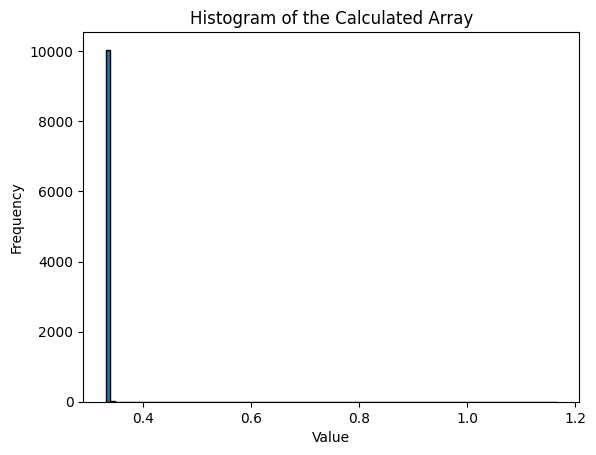

In [ ]:
plt.hist(test_variance, bins=100, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the Calculated Array')
plt.show()

### Calculate Coverage Probability

In [ ]:
def calculate_coverage_probability(y_true, lower_bound, upper_bound):

    # Count how many true values fall within the prediction intervals
    covered = ((y_true >= lower_bound) & (y_true <= upper_bound)).sum()

    # Calculate the coverage probability
    coverage_probability = covered / len(y_true)

    return coverage_probability

# Calculate coverage probability for training data
# train_coverage_probability = calculate_coverage_probability(train_y_original, train_lower_original, train_upper_original)

# Calculate coverage probability for test data
test_coverage_probability = calculate_coverage_probability(test_y_original, test_lower_original, test_upper_original)

# Output the results
# print(f"Training Data Coverage Probability: {train_coverage_probability}")
print(f"Test Data Coverage Probability: {test_coverage_probability}")

Test Data Coverage Probability: 1.0


### Calculate RMSE and Standard Error of model on training and testing data

In [ ]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Function to calculate Standard Error
def standard_error(y_true, y_pred):
    std_dev = np.std(y_true - y_pred)
    return std_dev / np.sqrt(len(y_true))

def calculate_nlpd(predicted_mean, predicted_var, actual_y):

    # Calculate the Gaussian PDF value for each test point
    pdf_values = 1 / np.sqrt(2 * np.pi * predicted_var) * np.exp(-0.5 * (actual_y - predicted_mean)**2 / predicted_var)

    pdf_values = pdf_values[pdf_values>0]
    # Calculate the Negative Log-Predictive Density (NLPD)
    nlpd = -np.mean(np.log(pdf_values))

    return nlpd


# Calculate RMSE and NLPD for training data
# train_rmse = rmse(train_y_original, train_mean_original)
# train_se = standard_error(train_y_original, train_mean_original)
# train_nlpd = calculate_nlpd(train_mean_original,train_variance_original, train_y_original)

# Calculate RMSE and NLPD for test data
test_rmse = rmse(test_y_original, test_mean_original)
# test_se = standard_error(test_y_original, test_mean_original)
test_nlpd = calculate_nlpd(test_mean_original, test_variance_original , test_y_original)

In [ ]:
print('Test RMSE: ', test_rmse)
print('Test NLPD: ', test_nlpd)

Test RMSE:  60.147996658345335
Test NLPD:  6.2715479736231


### Making Plots

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

def update_plot(x_range):
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(20, 10))

    # Set x-axis range
    start, end = x_range
    ax.set_xlim(start, end)

    # # Initialize plot
    # f, ax = plt.subplots(1, 1, figsize=(20, 10))

    # Plot training data as green circles
    ax.plot(train_y_original, 'b-', markersize=0.5, label="Training Data")

    # # Plot predicted line for training data
    # ax.plot(train_mean_original, 'b-', label="Training Predicted Line")

    # # Plot confidence interval for training data
    # ax.fill_between(range(len(train_y_original)), train_lower_original, train_upper_original, alpha=0.2, color='blue', label="Training Confidence Interval")

    # Plot test data as red points
    ax.scatter(range(len(train_y_original), len(train_y_original) + len(test_y_original)), test_y_original, marker='o', color='black', s=1 , label="Test Data")

    # Plot predicted line for test data
    ax.plot(range(len(train_y_original), len(train_y_original) + len(test_y_original)), test_mean_original, 'r--', label="Test Predictive Line")

    # Plot confidence interval for test data
    ax.fill_between(range(len(train_y_original), len(train_y_original) + len(test_y_original)), test_lower_original, test_upper_original, alpha=0.2, color='red', label="Test Confidence Interval")

    # Labels and title
    ax.set_xlabel("Time (10-min Intervals)")
    ax.set_ylabel("Power")
    ax.set_title("GP Prediction with Training and Test Data")
    ax.legend()

    # Annotate RMSE and Standard Error for training and testing on the plot
    # ax.annotate(f'Training RMSE: {train_rmse:.4f}', xy=(0.5, 0.9), xycoords='axes fraction')
    # ax.annotate(f'Training NLPD: {train_nlpd:.4f}', xy=(0.5, 0.85), xycoords='axes fraction')
    ax.annotate(f'Test RMSE: {test_rmse:.4f}', xy=(0.5, 0.8), xycoords='axes fraction')
    ax.annotate(f'Test NLPD: {test_nlpd:.4f}', xy=(0.5, 0.75), xycoords='axes fraction')

    # Show plot
    plt.show()

# Create the slider for x-axis range
x_max = len(train_y_original) + len(test_y_original)  # Assuming train_y_original and test_y_original are your data
x_slider = widgets.IntRangeSlider(
    value=[0, x_max],
    min=0,
    max=x_max,
    step=1,
    description='X-axis Range:',
    continuous_update=False
)

# Show the interactive plot
interact(update_plot, x_range=x_slider)

interactive(children=(IntRangeSlider(value=(0, 17080), continuous_update=False, description='X-axis Range:', m…

<function __main__.update_plot(x_range)>

### Plot of predicted vs observed values of Power

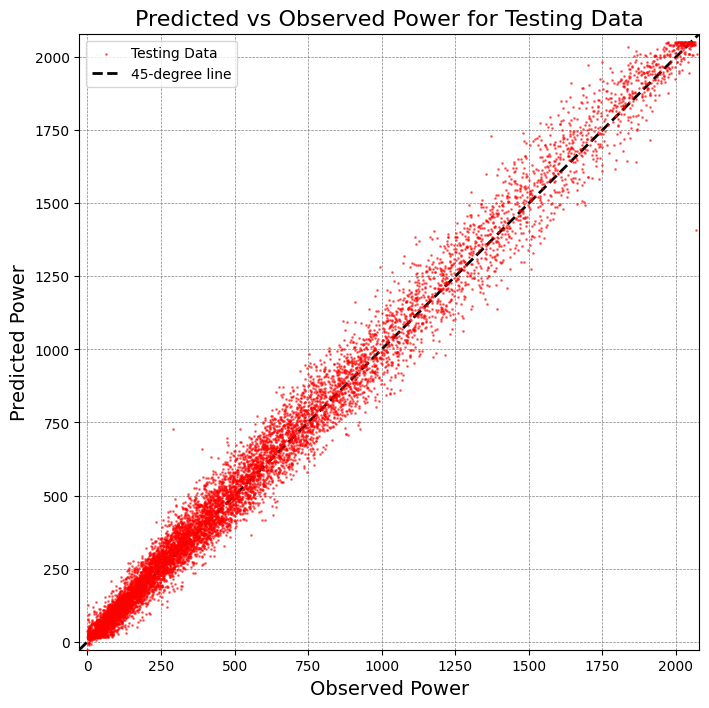

In [ ]:
# Find the minimum and maximum values for the x and y axes
min_val = min(train_y_original.min(), test_y_original.min(), 0, test_mean_original.min())
max_val = max(train_y_original.max(), test_y_original.max(), 2000, test_mean_original.max())

# Create a subplot with enhanced aesthetics
f2, ax2 = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for training data
# ax2.scatter(train_y_original, train_mean_original, color='blue', alpha=0.5, s=1, label='Training Data', zorder=5)

# Scatter plot for testing data
ax2.scatter(test_y_original, test_mean_original, color='red', alpha=0.5, s=1, label='Testing Data', zorder=5)

# 45-degree line through the origin
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='45-degree line')

# Set the limits for x and y axes
ax2.set_xlim([min_val, max_val])
ax2.set_ylim([min_val, max_val])

# Aesthetic improvements
ax2.set_xlabel('Observed Power', fontsize=14)
ax2.set_ylabel('Predicted Power', fontsize=14)
ax2.set_title('Predicted vs Observed Power for Testing Data', fontsize=16)
ax2.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax2.legend(loc='upper left')

plt.show()
